In [83]:
import pickle
with open("data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

### Sanity Check

In [72]:
import numpy as np
from sklearn.model_selection import train_test_split

#  Generate synthetic dataset
np.random.seed(42)
N = 5000
x = np.random.uniform(0, 10, N)
A = np.random.uniform(0.5, 2.0, N)
B = np.random.uniform(0.5, 3.0, N)
C = np.random.uniform(0.5, 2.0, N)
D = np.random.uniform(0.5, 3.0, N)

y = A * np.sin(B * x) + C * np.cos(D * x)

# Stack features (x, A, B, C, D) into a feature matrix
X = np.stack([x, A, B, C, D], axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.datasets import make_regression
import torch
from torch.utils.data import TensorDataset, DataLoader

# Generate random regression dataset
X, y = make_regression(n_samples=1000, n_features=65, noise=0.1)

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

## Neural Network

In [84]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed


In [92]:
import pandas as pd

def convert_to_tensor(data):
    """
    Convert numpy arrays and pandas datasets to PyTorch tensors.
    """
    if isinstance(data, np.ndarray):
        return torch.tensor(data, dtype=torch.float)
    elif isinstance(data, (pd.DataFrame, pd.Series)):
        return torch.tensor(data.values, dtype=torch.float)
    elif isinstance(data, torch.Tensor):
        return data
    else:
        raise ValueError(f"Unsupported data type: {type(data)}")

X_train = convert_to_tensor(X_train)
y_train = convert_to_tensor(y_train)
X_test = convert_to_tensor(X_test)
y_test = convert_to_tensor(y_test)
for data in [X_train, y_train, X_test, y_test]:
    print(f"Data type: {type(data)}, Shape: {data.shape}, Device: {data.device}")

Data type: <class 'torch.Tensor'>, Shape: torch.Size([6114, 65]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([6114, 1]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([1529, 65]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([1529, 1]), Device: cpu


In [93]:
class ColCanDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [94]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        # calulate the number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        elif opt_method == "sgdm":
            # Hint: to use SGDM in PyTorch, use torch.optim.SGD and set momentum to a non-zero value
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list = []
        val_loss_list = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.MSELoss()

        for n in tqdm(range(self.epoch), leave=False):
            # enable train mode
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.float()  # Convert input batch to float32
                y_batch = y_batch.float()  # Convert target batch to float32 (if necessary)
                batch_importance = y_batch.shape[0] / len(train_data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
                            
            # call the evaluate function
            train_loss = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            
            val_loss = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            plt.figure(figsize=(6, 4))
            plt.plot(x_axis, train_loss_list, label="Train")
            plt.plot(x_axis, val_loss_list, label="Validation")
            plt.title("Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }
    
    def evaluate(self, data):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=False)
        loss_func = nn.MSELoss()
        loss = 0.0
        for X_batch, y_batch in loader:
            X_batch = X_batch.float()  # Convert input batch to float32
            y_batch = y_batch.float()  # Convert target batch to float32 (if necessary)
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                loss += batch_loss.detach().cpu().item() * batch_importance
        return loss            

In [ ]:
def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
):
    # Use ColCanDataset to organize data
    test_data = ColCanDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle = True, random_state=42)
    train_mse_list, test_mse_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        # Use ColCanDataset to organize data
        train_data = ColCanDataset(X_train[train_index], y_train[train_index])
        val_data = ColCanDataset(X_train[val_index], y_train[val_index])
        
        model = model_class().float()
        # initialize a Trainer object
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        # call trainer.train() here
        print(f'train_data.X.shape: {train_data.X.shape}, val_data.X.shape: {val_data.X.shape}')
        print(f'train_data.y.shape: {train_data.y.shape}, val_data.y.shape: {val_data.y.shape}')
        res = trainer.train(train_data, val_data)
        # record the training accuracy of the epoch that has the lowest validation lost
        # Hint: use np.argmin
        train_mse_best = res["train_loss_list"][np.argmin(res["val_loss_list"])]
        # test, use trainer.evaluate function
        test_mse = trainer.evaluate(test_data)
        
        train_mse_list.append(train_mse_best)
        test_mse_list.append(test_mse)
        
        print(f"Training MSE: {train_mse_best: .4f}")
        print(f"Test MSE: {test_mse: .4f}")
    
    
    print("Final results:")
    # Report mean and std
    print(f"Training MSE: {np.mean(train_mse_list)} +/- {np.std(train_mse_list)}")
    print(f"Test MSE: {np.mean(test_mse_list)} +/- {np.std(test_mse_list)}")

In [99]:
class MLP(nn.Module):
    def __init__(self, input_size=65):
        super(MLP, self).__init__()
        self.layers= nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

Fold 0:
MLP - Number of parameters: 2145
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


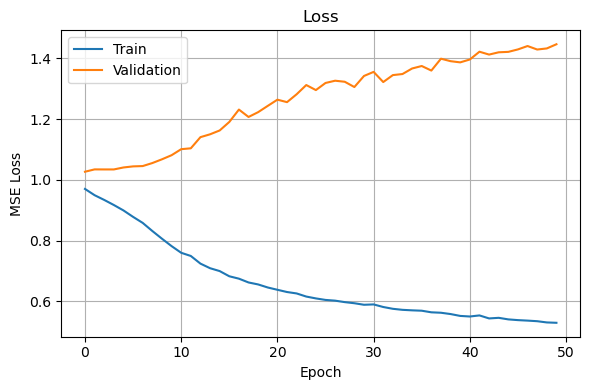

func: train took: 5.3491 sec
Training MSE:  0.9700
Test MSE:  1.4717
Fold 1:
MLP - Number of parameters: 2145
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


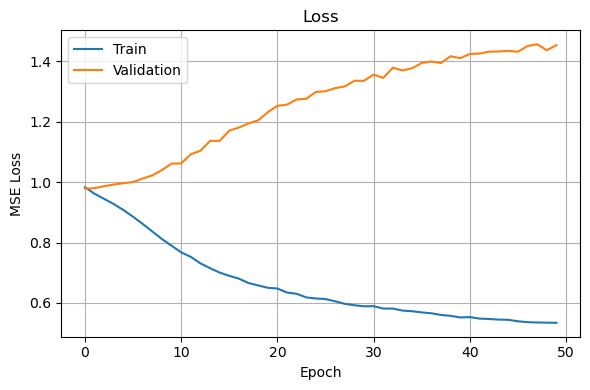

func: train took: 5.0956 sec
Training MSE:  0.9829
Test MSE:  1.4720
Fold 2:
MLP - Number of parameters: 2145
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


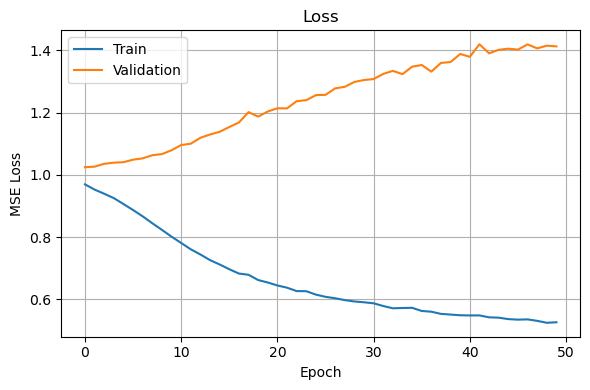

func: train took: 5.0348 sec
Training MSE:  0.9693
Test MSE:  1.4528
Fold 3:
MLP - Number of parameters: 2145
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


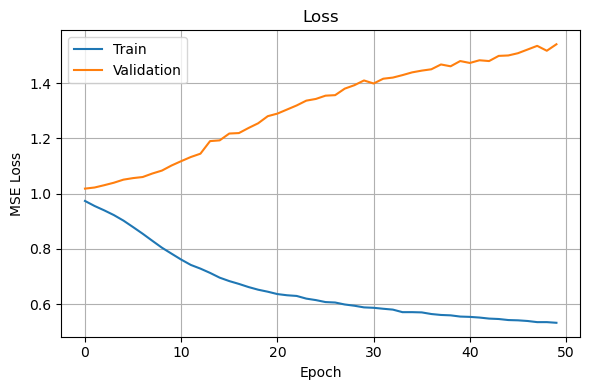

func: train took: 5.3503 sec
Training MSE:  0.9734
Test MSE:  1.4828
Fold 4:
MLP - Number of parameters: 2145
train_data.X.shape: torch.Size([4892, 65]), val_data.X.shape: torch.Size([1222, 65])
train_data.y.shape: torch.Size([4892, 1]), val_data.y.shape: torch.Size([1222, 1])


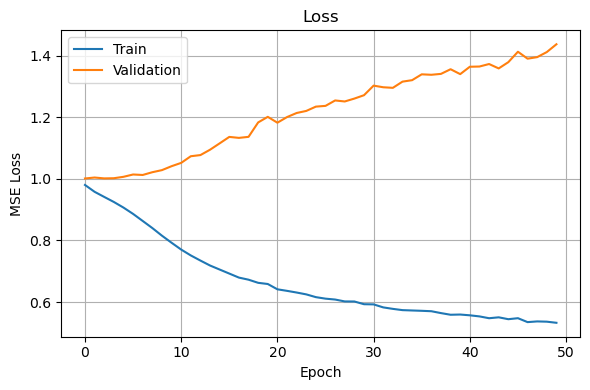

func: train took: 5.2015 sec
Training MSE:  0.9800
Test MSE:  1.3839
Final results:
Training MSE: 0.9751206410966151 +/- 0.005425120954052386
Test MSE: 1.4526407420674208 +/- 0.035724276188044767


In [98]:
model_class= lambda: MLP(input_size=X_train.shape[1])
k=5
KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
)

### Hyperparameter tuning

In [106]:
def KFoldCrossValidation2(
    model_class, k, 
    X_train, y_train, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
):
    """
    Perform K-Fold Cross Validation without touching the test set.
    Returns average training and validation loss across folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    train_mse_list, val_mse_list = [], []

    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        #print(f"Fold {i+1}/{k}:")

        train_data = ColCanDataset(X_train[train_index], y_train[train_index])
        val_data = ColCanDataset(X_train[val_index], y_train[val_index])
        
        model = model_class().float()
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)

        res = trainer.train(train_data, val_data, early_stop=True, draw_curve=False)

        train_mse_best = res["train_loss_list"][np.argmin(res["val_loss_list"])]
        val_mse_best = res["val_loss_list"][np.argmin(res["val_loss_list"])]

        train_mse_list.append(train_mse_best)
        val_mse_list.append(val_mse_best)

        #print(f"Train MSE (best): {train_mse_best:.4f}")
        #print(f"Val MSE (best):   {val_mse_best:.4f}")

    avg_train_mse = np.mean(train_mse_list)
    avg_val_mse = np.mean(val_mse_list)

    print(f"\n✅ Cross-Validation Results over {k} folds:")
    print(f"→ Avg Train MSE: {avg_train_mse:.4f}")
    print(f"→ Avg Val MSE:   {avg_val_mse:.4f}")

    return avg_train_mse, avg_val_mse


In [107]:
class DeepMLP(nn.Module):
    def __init__(self, input_size=65, dropout=0.3):
        super(DeepMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),  # helps prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [108]:
from itertools import product

learning_rates = [1e-2, 1e-3, 5e-4]
batch_size=[32, 64, 128]
l2_regs = [1e-5, 1e-4, 1e-3]
dropouts = [0.2, 0.3, 0.5, 0.7]

best_val_loss = float('inf')
best_config = None

for lr, bs, l2, do in product(learning_rates, batch_size, l2_regs, dropouts):
    print(f"\n🔧 Testing: LR={lr}, Batch Size={bs}, L2={l2}, Dropout={do}")

    model_class = lambda: DeepMLP(input_size=X_train.shape[1], dropout=do)

    avg_train_loss, avg_val_loss = KFoldCrossValidation2(
        model_class=model_class,
        k=5,
        X_train=X_train, y_train=y_train,
        opt_method='adam',
        learning_rate=lr,
        batch_size=bs,
        epoch=50,
        l2=l2
    )

    print(f"→ Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_config = (lr, bs, l2, do)

print(f"\n✅ Best Config: LR={best_config[0]}, Batch Size= {best_config[1]}, L2={best_config[2]}, Dropout={best_config[3]}")



🔧 Testing: LR=0.01, Batch Size=32, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 15.3105 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.1880 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.8360 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4359 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.2130 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9824
→ Avg Val MSE:   0.9979
→ Avg Train Loss: 0.9824, Avg Val Loss: 0.9979

🔧 Testing: LR=0.01, Batch Size=32, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 15.7657 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4548 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.3392 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4728 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.0475 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9840
→ Avg Val MSE:   0.9959
→ Avg Train Loss: 0.9840, Avg Val Loss: 0.9959

🔧 Testing: LR=0.01, Batch Size=32, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 15.0335 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.1243 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.1078 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.0029 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.0713 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9989
→ Avg Val MSE:   0.9959
→ Avg Train Loss: 0.9989, Avg Val Loss: 0.9959

🔧 Testing: LR=0.01, Batch Size=32, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 15.1548 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.1596 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.3910 sec
DeepMLP - Number of parameters: 16769


func: train took: 18.9176 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.4955 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9994
→ Avg Val MSE:   0.9964
→ Avg Train Loss: 0.9994, Avg Val Loss: 0.9964

🔧 Testing: LR=0.01, Batch Size=32, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 18.0821 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.2078 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.7110 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.3794 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.7954 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9919
→ Avg Val MSE:   0.9977
→ Avg Train Loss: 0.9919, Avg Val Loss: 0.9977

🔧 Testing: LR=0.01, Batch Size=32, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 15.9866 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.3935 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5951 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5252 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5556 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9918
→ Avg Val MSE:   0.9969
→ Avg Train Loss: 0.9918, Avg Val Loss: 0.9969

🔧 Testing: LR=0.01, Batch Size=32, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 15.4694 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4329 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.8353 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4717 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5730 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 1.0001
→ Avg Val MSE:   0.9946
→ Avg Train Loss: 1.0001, Avg Val Loss: 0.9946

🔧 Testing: LR=0.01, Batch Size=32, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 15.7216 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4811 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5072 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4341 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.7638 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9988
→ Avg Val MSE:   0.9966
→ Avg Train Loss: 0.9988, Avg Val Loss: 0.9966

🔧 Testing: LR=0.01, Batch Size=32, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 16.0364 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.7505 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4652 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.8482 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4761 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9944
→ Avg Val MSE:   0.9954
→ Avg Train Loss: 0.9944, Avg Val Loss: 0.9954

🔧 Testing: LR=0.01, Batch Size=32, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 15.6034 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4983 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.0102 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4474 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.3956 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9896
→ Avg Val MSE:   0.9947
→ Avg Train Loss: 0.9896, Avg Val Loss: 0.9947

🔧 Testing: LR=0.01, Batch Size=32, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 15.9426 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.1284 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5440 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5318 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5935 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9983
→ Avg Val MSE:   0.9947
→ Avg Train Loss: 0.9983, Avg Val Loss: 0.9947

🔧 Testing: LR=0.01, Batch Size=32, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 15.9614 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.8342 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.2171 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.1179 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.0379 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9994
→ Avg Val MSE:   0.9954
→ Avg Train Loss: 0.9994, Avg Val Loss: 0.9954

🔧 Testing: LR=0.01, Batch Size=64, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 9.2481 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.3681 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.3447 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8567 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.5643 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9849
→ Avg Val MSE:   0.9983
→ Avg Train Loss: 0.9849, Avg Val Loss: 0.9983

🔧 Testing: LR=0.01, Batch Size=64, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 9.5842 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.9674 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.4430 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.3486 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7188 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9547
→ Avg Val MSE:   0.9973
→ Avg Train Loss: 0.9547, Avg Val Loss: 0.9973

🔧 Testing: LR=0.01, Batch Size=64, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 9.9341 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.4234 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6585 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.2592 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.4312 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9873
→ Avg Val MSE:   0.9943
→ Avg Train Loss: 0.9873, Avg Val Loss: 0.9943

🔧 Testing: LR=0.01, Batch Size=64, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 9.3976 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6580 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6034 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.2671 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.5871 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9985
→ Avg Val MSE:   0.9966
→ Avg Train Loss: 0.9985, Avg Val Loss: 0.9966

🔧 Testing: LR=0.01, Batch Size=64, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 9.6261 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.5371 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.5852 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.0115 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.2487 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9838
→ Avg Val MSE:   0.9984
→ Avg Train Loss: 0.9838, Avg Val Loss: 0.9984

🔧 Testing: LR=0.01, Batch Size=64, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 9.7195 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6384 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.1560 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.6985 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.1080 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9720
→ Avg Val MSE:   0.9969
→ Avg Train Loss: 0.9720, Avg Val Loss: 0.9969

🔧 Testing: LR=0.01, Batch Size=64, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 8.8496 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.1539 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9789 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.1661 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.7726 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9896
→ Avg Val MSE:   0.9939
→ Avg Train Loss: 0.9896, Avg Val Loss: 0.9939

🔧 Testing: LR=0.01, Batch Size=64, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 9.4651 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.2876 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.4984 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6264 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9662 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9979
→ Avg Val MSE:   0.9963
→ Avg Train Loss: 0.9979, Avg Val Loss: 0.9963

🔧 Testing: LR=0.01, Batch Size=64, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 9.3378 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9797 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.0107 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.2620 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.0072 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9761
→ Avg Val MSE:   0.9952
→ Avg Train Loss: 0.9761, Avg Val Loss: 0.9952

🔧 Testing: LR=0.01, Batch Size=64, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 9.0572 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.0783 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9389 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9852 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.0299 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9667
→ Avg Val MSE:   0.9954
→ Avg Train Loss: 0.9667, Avg Val Loss: 0.9954

🔧 Testing: LR=0.01, Batch Size=64, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 9.1244 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.0429 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.0413 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.0122 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.1021 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9949
→ Avg Val MSE:   0.9948
→ Avg Train Loss: 0.9949, Avg Val Loss: 0.9948

🔧 Testing: LR=0.01, Batch Size=64, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 9.3277 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9536 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8209 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9657 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8765 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9986
→ Avg Val MSE:   0.9962
→ Avg Train Loss: 0.9986, Avg Val Loss: 0.9962

🔧 Testing: LR=0.01, Batch Size=128, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 6.3055 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.4119 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2212 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.1974 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.4290 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9801
→ Avg Val MSE:   0.9981
→ Avg Train Loss: 0.9801, Avg Val Loss: 0.9981

🔧 Testing: LR=0.01, Batch Size=128, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 6.1905 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2877 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2544 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2261 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8809 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9821
→ Avg Val MSE:   0.9993
→ Avg Train Loss: 0.9821, Avg Val Loss: 0.9993

🔧 Testing: LR=0.01, Batch Size=128, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 6.3415 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2430 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2635 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2612 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2136 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9687
→ Avg Val MSE:   0.9948
→ Avg Train Loss: 0.9687, Avg Val Loss: 0.9948

🔧 Testing: LR=0.01, Batch Size=128, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 6.2765 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2618 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2508 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2907 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2693 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9972
→ Avg Val MSE:   0.9961
→ Avg Train Loss: 0.9972, Avg Val Loss: 0.9961

🔧 Testing: LR=0.01, Batch Size=128, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 6.2662 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2646 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2920 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.1684 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.1959 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9828
→ Avg Val MSE:   0.9994
→ Avg Train Loss: 0.9828, Avg Val Loss: 0.9994

🔧 Testing: LR=0.01, Batch Size=128, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 6.3130 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.0882 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2313 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2928 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.1842 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9680
→ Avg Val MSE:   0.9976
→ Avg Train Loss: 0.9680, Avg Val Loss: 0.9976

🔧 Testing: LR=0.01, Batch Size=128, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 6.1989 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.3146 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2980 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.3426 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.6179 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9592
→ Avg Val MSE:   0.9958
→ Avg Train Loss: 0.9592, Avg Val Loss: 0.9958

🔧 Testing: LR=0.01, Batch Size=128, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 6.2085 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2908 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.6921 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.6432 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.3968 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9965
→ Avg Val MSE:   0.9965
→ Avg Train Loss: 0.9965, Avg Val Loss: 0.9965

🔧 Testing: LR=0.01, Batch Size=128, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 6.6638 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.3880 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.1935 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.3523 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2502 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9740
→ Avg Val MSE:   0.9999
→ Avg Train Loss: 0.9740, Avg Val Loss: 0.9999

🔧 Testing: LR=0.01, Batch Size=128, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 6.3421 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.5587 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.6786 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.5114 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.4926 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9771
→ Avg Val MSE:   0.9963
→ Avg Train Loss: 0.9771, Avg Val Loss: 0.9963

🔧 Testing: LR=0.01, Batch Size=128, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 6.4267 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.0173 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.0760 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.0480 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.0088 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9620
→ Avg Val MSE:   0.9941
→ Avg Train Loss: 0.9620, Avg Val Loss: 0.9941

🔧 Testing: LR=0.01, Batch Size=128, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 6.0780 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.2360 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.6200 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.5554 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.4745 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9949
→ Avg Val MSE:   0.9954
→ Avg Train Loss: 0.9949, Avg Val Loss: 0.9954

🔧 Testing: LR=0.001, Batch Size=32, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 15.5192 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.3570 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.8796 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.9515 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5067 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9545
→ Avg Val MSE:   1.0021
→ Avg Train Loss: 0.9545, Avg Val Loss: 1.0021

🔧 Testing: LR=0.001, Batch Size=32, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 14.2738 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0525 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.8555 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.0764 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5418 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9724
→ Avg Val MSE:   0.9994
→ Avg Train Loss: 0.9724, Avg Val Loss: 0.9994

🔧 Testing: LR=0.001, Batch Size=32, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 15.8204 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.2938 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.8375 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.9996 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.4772 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9723
→ Avg Val MSE:   0.9984
→ Avg Train Loss: 0.9723, Avg Val Loss: 0.9984

🔧 Testing: LR=0.001, Batch Size=32, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 15.1343 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1765 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9344 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0749 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0451 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9476
→ Avg Val MSE:   0.9954
→ Avg Train Loss: 0.9476, Avg Val Loss: 0.9954

🔧 Testing: LR=0.001, Batch Size=32, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 14.0200 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9908 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1826 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0534 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0357 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9692
→ Avg Val MSE:   0.9998
→ Avg Train Loss: 0.9692, Avg Val Loss: 0.9998

🔧 Testing: LR=0.001, Batch Size=32, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 13.8802 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1049 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9663 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.8908 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.2481 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9588
→ Avg Val MSE:   1.0008
→ Avg Train Loss: 0.9588, Avg Val Loss: 1.0008

🔧 Testing: LR=0.001, Batch Size=32, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 14.4237 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1913 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.3035 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.4241 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9447 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9631
→ Avg Val MSE:   0.9988
→ Avg Train Loss: 0.9631, Avg Val Loss: 0.9988

🔧 Testing: LR=0.001, Batch Size=32, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 14.1861 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.2010 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.6662 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1216 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0212 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9664
→ Avg Val MSE:   0.9973
→ Avg Train Loss: 0.9664, Avg Val Loss: 0.9973

🔧 Testing: LR=0.001, Batch Size=32, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 14.1234 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0108 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9253 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.2467 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0425 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9633
→ Avg Val MSE:   0.9995
→ Avg Train Loss: 0.9633, Avg Val Loss: 0.9995

🔧 Testing: LR=0.001, Batch Size=32, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 14.0162 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9812 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9702 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9967 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9280 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9613
→ Avg Val MSE:   0.9968
→ Avg Train Loss: 0.9613, Avg Val Loss: 0.9968

🔧 Testing: LR=0.001, Batch Size=32, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 14.1288 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0987 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1918 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0283 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.5390 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9747
→ Avg Val MSE:   0.9960
→ Avg Train Loss: 0.9747, Avg Val Loss: 0.9960

🔧 Testing: LR=0.001, Batch Size=32, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 14.1441 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.0309 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1209 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.1469 sec
DeepMLP - Number of parameters: 16769


func: train took: 13.9580 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9709
→ Avg Val MSE:   0.9965
→ Avg Train Loss: 0.9709, Avg Val Loss: 0.9965

🔧 Testing: LR=0.001, Batch Size=64, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 8.6954 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.6990 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.7611 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.6486 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.7624 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9692
→ Avg Val MSE:   0.9987
→ Avg Train Loss: 0.9692, Avg Val Loss: 0.9987

🔧 Testing: LR=0.001, Batch Size=64, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 8.7062 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.7217 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8117 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.8307 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.1847 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9679
→ Avg Val MSE:   0.9998
→ Avg Train Loss: 0.9679, Avg Val Loss: 0.9998

🔧 Testing: LR=0.001, Batch Size=64, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 9.1428 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8809 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.7413 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8359 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6772 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9692
→ Avg Val MSE:   0.9967
→ Avg Train Loss: 0.9692, Avg Val Loss: 0.9967

🔧 Testing: LR=0.001, Batch Size=64, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 8.7197 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.7164 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.7822 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9712 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.5216 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9820
→ Avg Val MSE:   0.9968
→ Avg Train Loss: 0.9820, Avg Val Loss: 0.9968

🔧 Testing: LR=0.001, Batch Size=64, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 9.8730 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8579 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9971 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7619 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.8917 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9763
→ Avg Val MSE:   0.9984
→ Avg Train Loss: 0.9763, Avg Val Loss: 0.9984

🔧 Testing: LR=0.001, Batch Size=64, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 9.4825 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.7995 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.1757 sec
DeepMLP - Number of parameters: 16769


func: train took: 11.2584 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.3995 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9688
→ Avg Val MSE:   0.9967
→ Avg Train Loss: 0.9688, Avg Val Loss: 0.9967

🔧 Testing: LR=0.001, Batch Size=64, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 9.8678 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.1236 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7406 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6962 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7745 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9765
→ Avg Val MSE:   0.9972
→ Avg Train Loss: 0.9765, Avg Val Loss: 0.9972

🔧 Testing: LR=0.001, Batch Size=64, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 9.7034 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.8339 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.8438 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.8773 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.4233 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9786
→ Avg Val MSE:   0.9973
→ Avg Train Loss: 0.9786, Avg Val Loss: 0.9973

🔧 Testing: LR=0.001, Batch Size=64, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 10.9258 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.3641 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.4780 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.3526 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.8795 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9763
→ Avg Val MSE:   0.9995
→ Avg Train Loss: 0.9763, Avg Val Loss: 0.9995

🔧 Testing: LR=0.001, Batch Size=64, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 11.2011 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.7611 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.6917 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.7406 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.5952 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9661
→ Avg Val MSE:   0.9999
→ Avg Train Loss: 0.9661, Avg Val Loss: 0.9999

🔧 Testing: LR=0.001, Batch Size=64, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 10.6823 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.8686 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.5847 sec
DeepMLP - Number of parameters: 16769


func: train took: 11.0823 sec
DeepMLP - Number of parameters: 16769


func: train took: 11.1841 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9710
→ Avg Val MSE:   0.9946
→ Avg Train Loss: 0.9710, Avg Val Loss: 0.9946

🔧 Testing: LR=0.001, Batch Size=64, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 10.1672 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.8858 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.1737 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6571 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.9869 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9738
→ Avg Val MSE:   0.9972
→ Avg Train Loss: 0.9738, Avg Val Loss: 0.9972

🔧 Testing: LR=0.001, Batch Size=128, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 6.7911 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.7993 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8368 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8807 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.3955 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9750
→ Avg Val MSE:   0.9969
→ Avg Train Loss: 0.9750, Avg Val Loss: 0.9969

🔧 Testing: LR=0.001, Batch Size=128, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 9.2972 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.3273 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0149 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8353 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.7680 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9782
→ Avg Val MSE:   0.9993
→ Avg Train Loss: 0.9782, Avg Val Loss: 0.9993

🔧 Testing: LR=0.001, Batch Size=128, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 6.9956 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8267 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0935 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.3193 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0665 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9725
→ Avg Val MSE:   0.9987
→ Avg Train Loss: 0.9725, Avg Val Loss: 0.9987

🔧 Testing: LR=0.001, Batch Size=128, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 7.2117 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8337 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8559 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2743 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2104 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9778
→ Avg Val MSE:   0.9958
→ Avg Train Loss: 0.9778, Avg Val Loss: 0.9958

🔧 Testing: LR=0.001, Batch Size=128, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 6.8719 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.7885 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.1315 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2332 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2296 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9753
→ Avg Val MSE:   1.0011
→ Avg Train Loss: 0.9753, Avg Val Loss: 1.0011

🔧 Testing: LR=0.001, Batch Size=128, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 7.5696 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.1271 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4666 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.3526 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.6795 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9785
→ Avg Val MSE:   0.9981
→ Avg Train Loss: 0.9785, Avg Val Loss: 0.9981

🔧 Testing: LR=0.001, Batch Size=128, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 8.0959 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9088 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0299 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2816 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.2325 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9771
→ Avg Val MSE:   0.9957
→ Avg Train Loss: 0.9771, Avg Val Loss: 0.9957

🔧 Testing: LR=0.001, Batch Size=128, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 8.3425 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.8567 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4298 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5448 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.6669 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9865
→ Avg Val MSE:   0.9958
→ Avg Train Loss: 0.9865, Avg Val Loss: 0.9958

🔧 Testing: LR=0.001, Batch Size=128, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 6.9856 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8661 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4016 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4004 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.6397 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9685
→ Avg Val MSE:   0.9991
→ Avg Train Loss: 0.9685, Avg Val Loss: 0.9991

🔧 Testing: LR=0.001, Batch Size=128, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 7.2082 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8109 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4671 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4820 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2597 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9708
→ Avg Val MSE:   0.9967
→ Avg Train Loss: 0.9708, Avg Val Loss: 0.9967

🔧 Testing: LR=0.001, Batch Size=128, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 7.7449 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4254 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5552 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4333 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8760 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9734
→ Avg Val MSE:   0.9968
→ Avg Train Loss: 0.9734, Avg Val Loss: 0.9968

🔧 Testing: LR=0.001, Batch Size=128, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 6.9098 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8756 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2130 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.9476 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.3569 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9777
→ Avg Val MSE:   0.9960
→ Avg Train Loss: 0.9777, Avg Val Loss: 0.9960

🔧 Testing: LR=0.0005, Batch Size=32, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 16.4607 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.3265 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.4088 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.2077 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.5834 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9783
→ Avg Val MSE:   1.0011
→ Avg Train Loss: 0.9783, Avg Val Loss: 1.0011

🔧 Testing: LR=0.0005, Batch Size=32, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 16.0621 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.2827 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.6815 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.3142 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.8600 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9742
→ Avg Val MSE:   0.9987
→ Avg Train Loss: 0.9742, Avg Val Loss: 0.9987

🔧 Testing: LR=0.0005, Batch Size=32, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 16.5040 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.8833 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5915 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.3067 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.5502 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9754
→ Avg Val MSE:   0.9984
→ Avg Train Loss: 0.9754, Avg Val Loss: 0.9984

🔧 Testing: LR=0.0005, Batch Size=32, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 15.1792 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.5087 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.6678 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5878 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.7783 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9711
→ Avg Val MSE:   0.9961
→ Avg Train Loss: 0.9711, Avg Val Loss: 0.9961

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 15.9150 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.2848 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.2052 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.1132 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.4197 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9685
→ Avg Val MSE:   1.0001
→ Avg Train Loss: 0.9685, Avg Val Loss: 1.0001

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 15.6883 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.2828 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4979 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.7248 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.9254 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9696
→ Avg Val MSE:   0.9985
→ Avg Train Loss: 0.9696, Avg Val Loss: 0.9985

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 16.1200 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.9962 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.9551 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.3900 sec
DeepMLP - Number of parameters: 16769


func: train took: 14.6245 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9740
→ Avg Val MSE:   0.9960
→ Avg Train Loss: 0.9740, Avg Val Loss: 0.9960

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 16.6830 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.8187 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.7240 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.7958 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.7598 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9870
→ Avg Val MSE:   0.9976
→ Avg Train Loss: 0.9870, Avg Val Loss: 0.9976

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 16.8479 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.0599 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.9773 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.6782 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.6831 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9665
→ Avg Val MSE:   0.9999
→ Avg Train Loss: 0.9665, Avg Val Loss: 0.9999

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 18.1830 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.2622 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.9662 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.3693 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.5075 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9773
→ Avg Val MSE:   0.9977
→ Avg Train Loss: 0.9773, Avg Val Loss: 0.9977

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 15.3835 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4417 sec
DeepMLP - Number of parameters: 16769


func: train took: 15.4482 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.5933 sec
DeepMLP - Number of parameters: 16769


func: train took: 17.1693 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9805
→ Avg Val MSE:   0.9965
→ Avg Train Loss: 0.9805, Avg Val Loss: 0.9965

🔧 Testing: LR=0.0005, Batch Size=32, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 17.6979 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.9146 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.5563 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.5181 sec
DeepMLP - Number of parameters: 16769


func: train took: 16.2737 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9860
→ Avg Val MSE:   0.9967
→ Avg Train Loss: 0.9860, Avg Val Loss: 0.9967

🔧 Testing: LR=0.0005, Batch Size=64, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 11.0650 sec
DeepMLP - Number of parameters: 16769


func: train took: 11.4684 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.0812 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7188 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6678 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9822
→ Avg Val MSE:   0.9983
→ Avg Train Loss: 0.9822, Avg Val Loss: 0.9983

🔧 Testing: LR=0.0005, Batch Size=64, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 9.5964 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7501 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.2038 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.2016 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.2519 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9712
→ Avg Val MSE:   1.0002
→ Avg Train Loss: 0.9712, Avg Val Loss: 1.0002

🔧 Testing: LR=0.0005, Batch Size=64, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 10.3113 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7957 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7553 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.1055 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.8680 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9795
→ Avg Val MSE:   0.9970
→ Avg Train Loss: 0.9795, Avg Val Loss: 0.9970

🔧 Testing: LR=0.0005, Batch Size=64, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 9.6240 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.4491 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.5006 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6914 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.3327 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9773
→ Avg Val MSE:   0.9959
→ Avg Train Loss: 0.9773, Avg Val Loss: 0.9959

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 9.7748 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.9757 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.2523 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.2899 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.3783 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9694
→ Avg Val MSE:   0.9986
→ Avg Train Loss: 0.9694, Avg Val Loss: 0.9986

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 10.3035 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.4346 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.8629 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.9767 sec
DeepMLP - Number of parameters: 16769


func: train took: 11.6273 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9792
→ Avg Val MSE:   0.9981
→ Avg Train Loss: 0.9792, Avg Val Loss: 0.9981

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 11.3790 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.9045 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.0267 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.8838 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.1941 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9788
→ Avg Val MSE:   0.9991
→ Avg Train Loss: 0.9788, Avg Val Loss: 0.9991

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 10.8360 sec
DeepMLP - Number of parameters: 16769


func: train took: 11.6934 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.2277 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.4698 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.3503 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9671
→ Avg Val MSE:   0.9958
→ Avg Train Loss: 0.9671, Avg Val Loss: 0.9958

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 10.3734 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.9723 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7625 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6263 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.2367 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9795
→ Avg Val MSE:   1.0016
→ Avg Train Loss: 0.9795, Avg Val Loss: 1.0016

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 10.1457 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.1686 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.3415 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.9927 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6020 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9754
→ Avg Val MSE:   0.9982
→ Avg Train Loss: 0.9754, Avg Val Loss: 0.9982

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 9.5697 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.8871 sec
DeepMLP - Number of parameters: 16769


func: train took: 11.0343 sec
DeepMLP - Number of parameters: 16769


func: train took: 10.0466 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.7133 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9778
→ Avg Val MSE:   0.9976
→ Avg Train Loss: 0.9778, Avg Val Loss: 0.9976

🔧 Testing: LR=0.0005, Batch Size=64, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 9.5699 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.5948 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6785 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6901 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.6357 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9734
→ Avg Val MSE:   0.9947
→ Avg Train Loss: 0.9734, Avg Val Loss: 0.9947

🔧 Testing: LR=0.0005, Batch Size=128, L2=1e-05, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 6.7925 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5875 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.9164 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.6404 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5096 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9810
→ Avg Val MSE:   0.9986
→ Avg Train Loss: 0.9810, Avg Val Loss: 0.9986

🔧 Testing: LR=0.0005, Batch Size=128, L2=1e-05, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 7.5137 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.8623 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.5343 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2875 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.1102 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9760
→ Avg Val MSE:   0.9976
→ Avg Train Loss: 0.9760, Avg Val Loss: 0.9976

🔧 Testing: LR=0.0005, Batch Size=128, L2=1e-05, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 6.8570 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.5795 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8409 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0647 sec
DeepMLP - Number of parameters: 16769


func: train took: 9.1066 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9801
→ Avg Val MSE:   0.9950
→ Avg Train Loss: 0.9801, Avg Val Loss: 0.9950

🔧 Testing: LR=0.0005, Batch Size=128, L2=1e-05, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 8.0605 sec
DeepMLP - Number of parameters: 16769


func: train took: 8.3443 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.1237 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0791 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.9446 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9802
→ Avg Val MSE:   0.9948
→ Avg Train Loss: 0.9802, Avg Val Loss: 0.9948

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.0001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 7.4972 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2309 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.9502 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.9296 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.3177 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9796
→ Avg Val MSE:   0.9996
→ Avg Train Loss: 0.9796, Avg Val Loss: 0.9996

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.0001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 7.6267 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5320 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.6189 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.7750 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5289 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9777
→ Avg Val MSE:   1.0006
→ Avg Train Loss: 0.9777, Avg Val Loss: 1.0006

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.0001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 7.0692 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0724 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.8742 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8832 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.3547 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9850
→ Avg Val MSE:   0.9962
→ Avg Train Loss: 0.9850, Avg Val Loss: 0.9962

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.0001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 7.4365 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.6085 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.9002 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8621 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8096 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9816
→ Avg Val MSE:   0.9966
→ Avg Train Loss: 0.9816, Avg Val Loss: 0.9966

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.001, Dropout=0.2
DeepMLP - Number of parameters: 16769


func: train took: 7.0003 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8841 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8435 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.3146 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2874 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9795
→ Avg Val MSE:   0.9988
→ Avg Train Loss: 0.9795, Avg Val Loss: 0.9988

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.001, Dropout=0.3
DeepMLP - Number of parameters: 16769


func: train took: 7.0761 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.1444 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5406 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4506 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.0562 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9784
→ Avg Val MSE:   0.9960
→ Avg Train Loss: 0.9784, Avg Val Loss: 0.9960

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.001, Dropout=0.5
DeepMLP - Number of parameters: 16769


func: train took: 6.9699 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.8716 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.7940 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5763 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.4942 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9792
→ Avg Val MSE:   0.9989
→ Avg Train Loss: 0.9792, Avg Val Loss: 0.9989

🔧 Testing: LR=0.0005, Batch Size=128, L2=0.001, Dropout=0.7
DeepMLP - Number of parameters: 16769


func: train took: 6.9426 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.2328 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.5329 sec
DeepMLP - Number of parameters: 16769


func: train took: 7.1413 sec
DeepMLP - Number of parameters: 16769


func: train took: 6.7431 sec

✅ Cross-Validation Results over 5 folds:
→ Avg Train MSE: 0.9876
→ Avg Val MSE:   0.9964
→ Avg Train Loss: 0.9876, Avg Val Loss: 0.9964

✅ Best Config: LR=0.01, Batch Size= 64, L2=0.0001, Dropout=0.5


Fold 0:
DeepMLP - Number of parameters: 16769
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


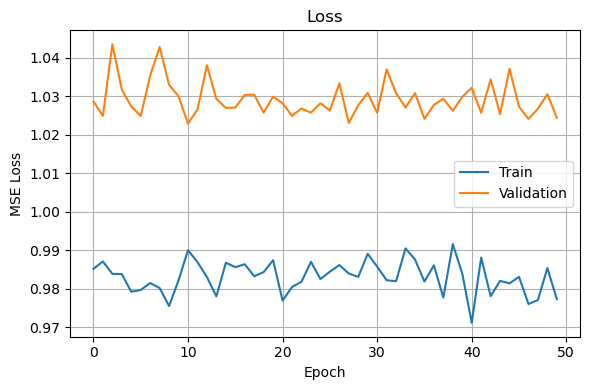

func: train took: 9.1749 sec
Training MSE:  0.9901
Test MSE:  1.0112
Fold 1:
DeepMLP - Number of parameters: 16769
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


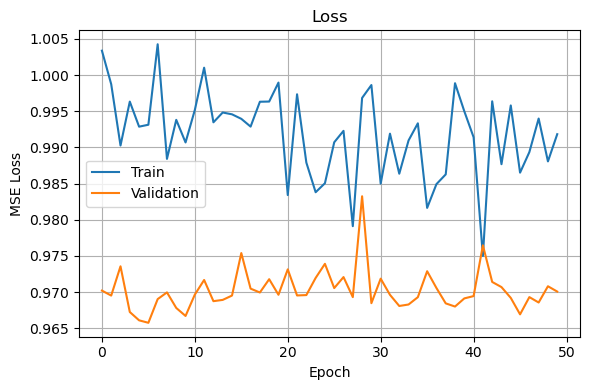

func: train took: 9.2566 sec
Training MSE:  0.9931
Test MSE:  1.0131
Fold 2:
DeepMLP - Number of parameters: 16769
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


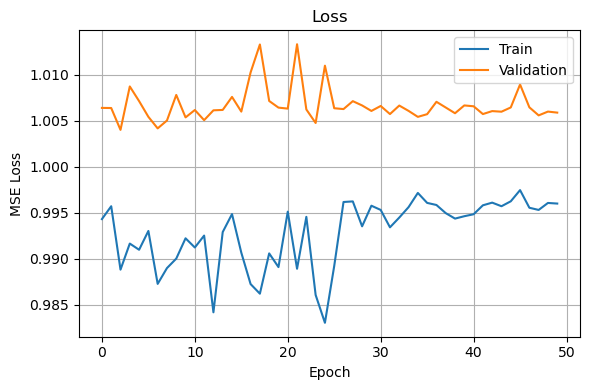

func: train took: 9.2134 sec
Training MSE:  0.9888
Test MSE:  1.0092
Fold 3:
DeepMLP - Number of parameters: 16769
train_data.X.shape: torch.Size([4891, 65]), val_data.X.shape: torch.Size([1223, 65])
train_data.y.shape: torch.Size([4891, 1]), val_data.y.shape: torch.Size([1223, 1])


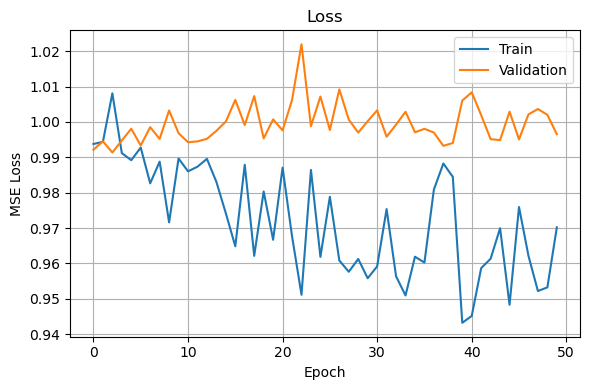

func: train took: 9.3742 sec
Training MSE:  1.0081
Test MSE:  1.0130
Fold 4:
DeepMLP - Number of parameters: 16769
train_data.X.shape: torch.Size([4892, 65]), val_data.X.shape: torch.Size([1222, 65])
train_data.y.shape: torch.Size([4892, 1]), val_data.y.shape: torch.Size([1222, 1])


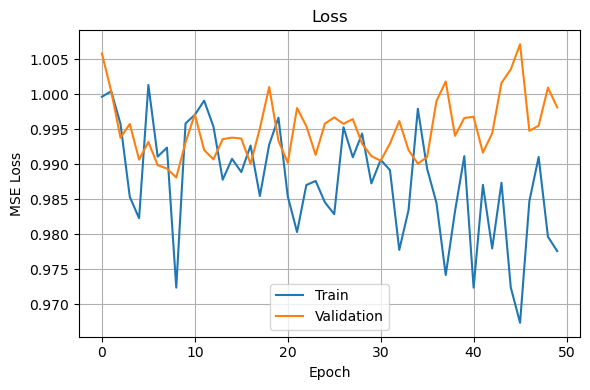

func: train took: 9.0256 sec
Training MSE:  0.9724
Test MSE:  1.0110
Final results:
Training MSE: 0.9905050358228212 +/- 0.011389475123148536
Test MSE: 1.011483882501127 +/- 0.0014545832792780223


In [112]:
best_model = lambda: DeepMLP(input_size=X_train.shape[1], dropout=best_config[3])
k=5
KFoldCrossValidation(
    best_model, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=best_config[0], batch_size=best_config[1], epoch=50, l2=best_config[2])

## Random Forest Regression

In [114]:
def convert_to_numpy(data):
    """
    Convert tensors to numpy arrays.
    """
    if isinstance(data, torch.Tensor):
        return np.array(data)
    elif isinstance(data, np.ndarray) or isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        return data
    else:
        raise ValueError(f"Unsupported data type: {type(data)}")

X_train = convert_to_numpy(X_train)
y_train = convert_to_numpy(y_train)
X_test = convert_to_numpy(X_test)
y_test = convert_to_numpy(y_test)
for data in [X_train, y_train, X_test, y_test]:
    print(f"Data type: {type(data)}, Shape: {data.shape}")

Data type: <class 'numpy.ndarray'>, Shape: (6114, 65)
Data type: <class 'numpy.ndarray'>, Shape: (6114, 1)
Data type: <class 'numpy.ndarray'>, Shape: (1529, 65)
Data type: <class 'numpy.ndarray'>, Shape: (1529, 1)


In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, tolerance=0.1):
    '''
    Function to evaluate the model performance.
    
    Input:
        y_true: True drug response values (1D array)
        y_pred: Predicted drug response values (1D array)
        
    Output:
        Prints Mean Squared Error, R-squared and mseuracy metrics.
    '''
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    accuracy = np.mean(np.abs(y_true - y_pred) < tolerance)
    
    print(f"Mean Squared Error: {mse: .4f}")
    print(f"R-squared: {r2: .4f}")
    print(f"Accuracy (within tolerance {tolerance}): {accuracy * 100:.2f}%")


def visualize_predictions(y_true, y_pred):
    ''' 
    Function to visualize the predictions of the model.

    Input:
        y_true: True drug response values (1D array)
        y_pred: Predicted drug response values (1D array)

    Output:
        Two plots: Residual plot and Prediction vs Actual plot
    '''    
    # Residual Plot
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # Prediction vs Actual Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted Drug Response')
    plt.show()

C:\Users\alice\AppData\Local\Temp\ipykernel_26720\3188642823.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Training Data Evaluation:
Mean Squared Error:  0.1412
R-squared:  0.8585
Accuracy (within tolerance 0.2): 32.19%
Testing Data Evaluation:
Mean Squared Error:  1.0254
R-squared: -0.0168
Accuracy (within tolerance 0.2): 11.64%
Training Data Visualization:


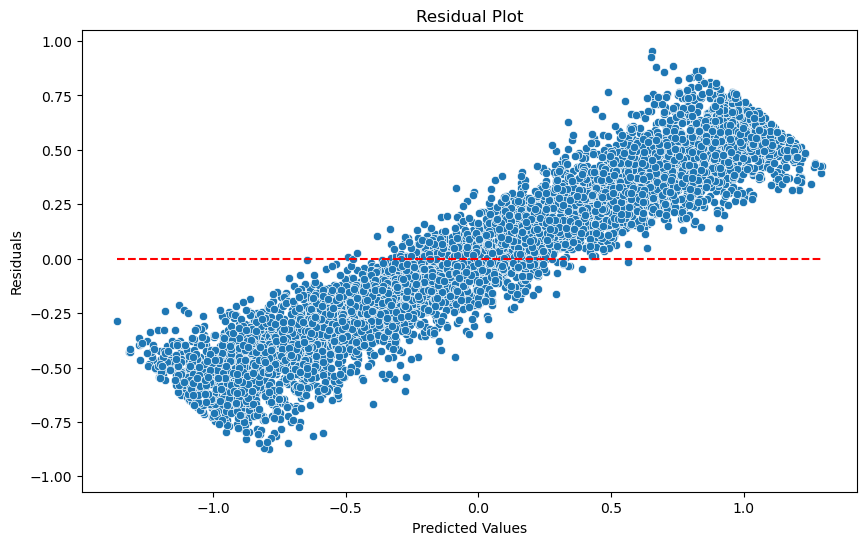

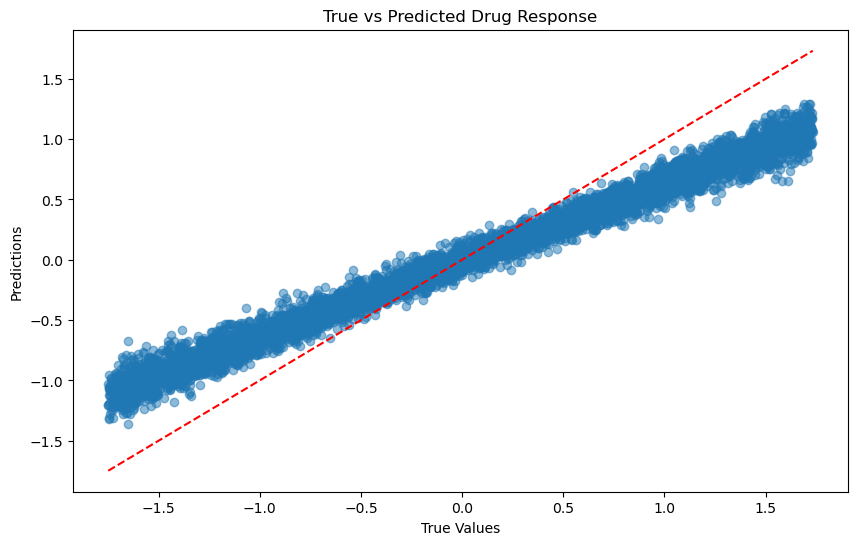

Testing Data Visualization:


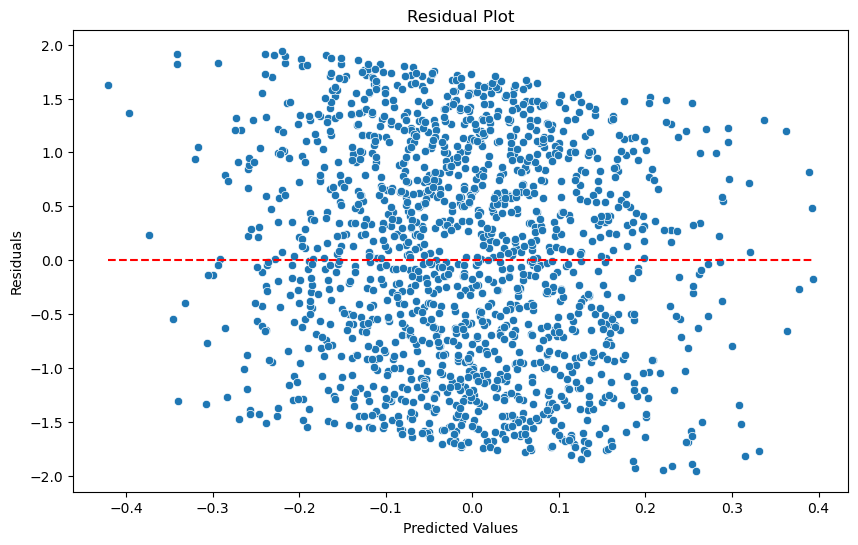

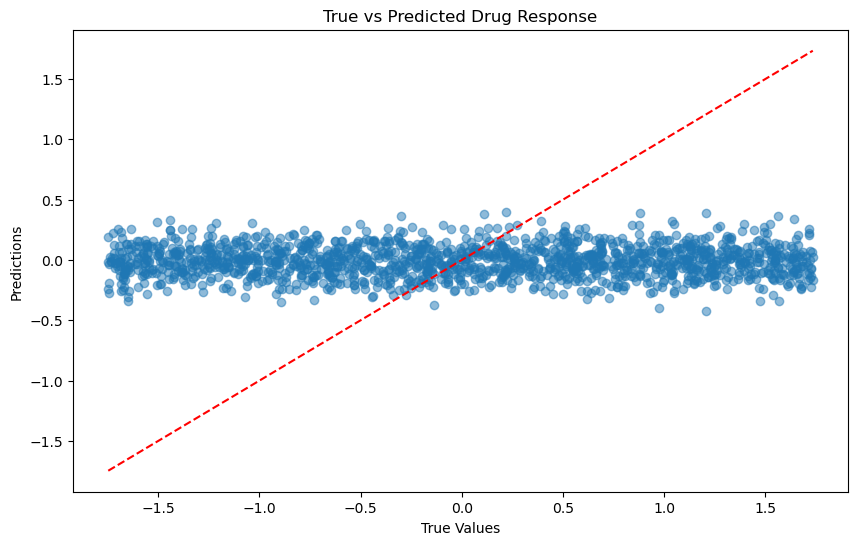

In [118]:
from sklearn.ensemble import RandomForestRegressor


# Initialize the model
rf = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=None,         # Maximum depth of the tree
    random_state=42,
    n_jobs=-1               # Use all processors
)

# Fit the model
rf.fit(X_train, y_train)

# Predict
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluate the model
print("Training Data Evaluation:")
evaluate_model(np.array(y_train).flatten(), y_pred_train, tolerance=0.2)
print("Testing Data Evaluation:")
evaluate_model(np.array(y_test).flatten(), y_pred_test, tolerance=0.2)

# Visualize the predictions
print("Training Data Visualization:")
visualize_predictions(np.array(y_train).flatten(), np.array(y_pred_train).flatten())
print("Testing Data Visualization:")
visualize_predictions(np.array(y_test).flatten(), np.array(y_pred_test).flatten())

# Feature Importance
#importances = pd.Series(rf.feature_importances_, index=X_train.columns)
#print(importances.sort_values(ascending=False).head(10))

c:\Users\alice\anaconda3\envs\c142\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 200}
Training Data Evaluation:
Mean Squared Error:  0.7515
R-squared:  0.2469
Accuracy (within tolerance 0.2): 13.25%
Testing Data Evaluation:
Mean Squared Error:  1.0129
R-squared: -0.0044
Accuracy (within tolerance 0.2): 11.84%
Training Data Visualization:


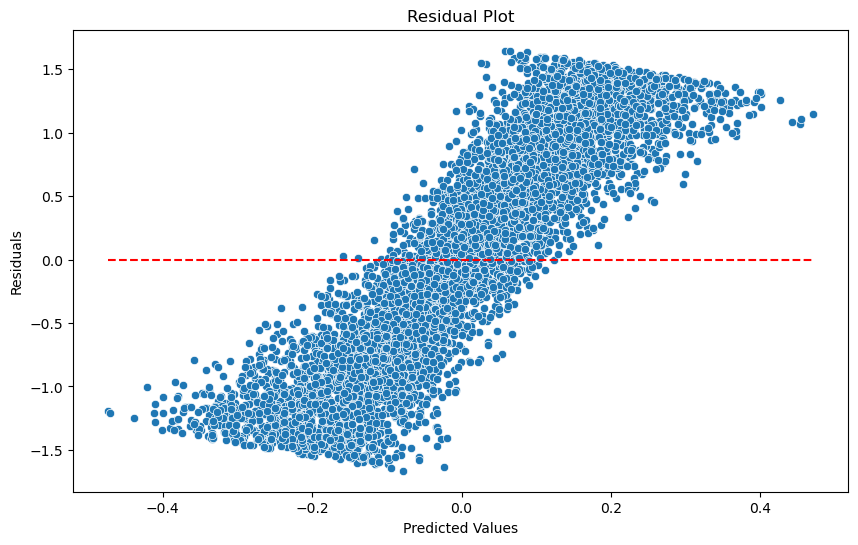

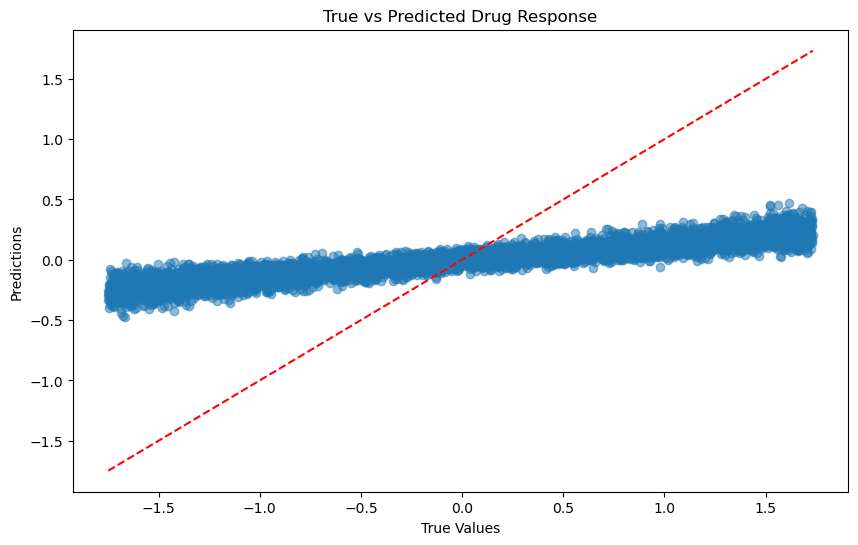

Testing Data Visualization:


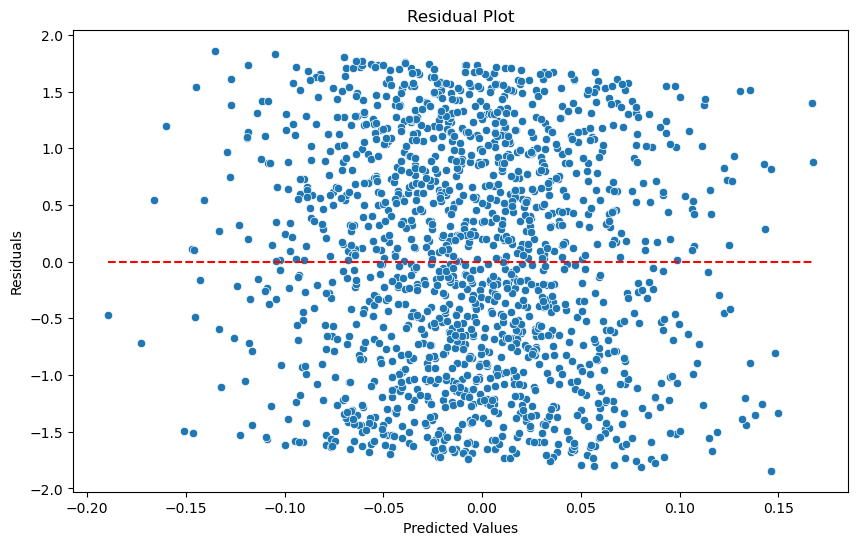

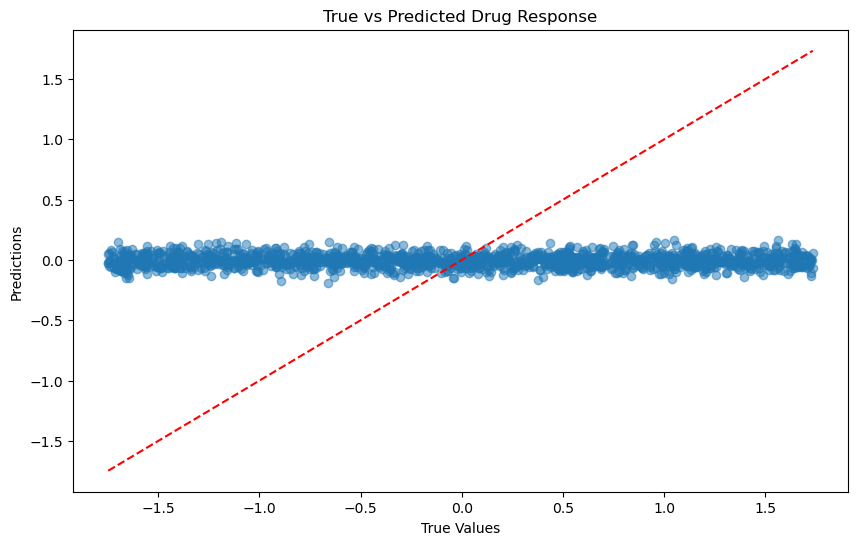

In [117]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluate the model
print("Training Data Evaluation:")
evaluate_model(np.array(y_train).flatten(), y_pred_train, tolerance=0.2)
print("Testing Data Evaluation:")
evaluate_model(np.array(y_test).flatten(), y_pred_test, tolerance=0.2)

# Visualize the predictions
print("Training Data Visualization:")
visualize_predictions(np.array(y_train).flatten(), np.array(y_pred_train).flatten())
print("Testing Data Visualization:")
visualize_predictions(np.array(y_test).flatten(), np.array(y_pred_test).flatten())